In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
import pandas as pd
import re

In [2]:
base_url = "https://www.moneycontrol.com/news/tags/companies.html"

is_appen_on_previous = True

if is_appen_on_previous:
    df = pd.read_csv('News.csv')
    print("Last News on : ",df.iloc[0]['date time'])
    print("Total news : ",len(df))
    
news_data = []

Last News on :  January 01, 2024 02:43 PM IST
Total news :  847


In [6]:
df

,link,title,date time,desc,content
0,https://www.moneycontrol.com/news/business/vec...,"VECV sales grow 11.1% to 8,026 units in Dec 2023","January 01, 2024 02:43 PM IST","VE Commercial Vehicles (VECV), a joint venture...",Eicher Motors Ltd on Monday said its arm VE Co...
1,https://www.moneycontrol.com/news/business/wor...,World needs India to become a reliable challen...,"January 01, 2024 04:29 PM IST","Anand Mahindra, Chairman of the Mahindra Group...","Anand Mahindra, Chairman of the Mahindra Group..."
2,https://www.moneycontrol.com/news/business/toy...,"Toyota Kirloskar Motor sales up 45% at 2,33,34...","January 01, 2024 02:34 PM IST","The company's wholesales stood at 1,60,364 uni...",Toyota Kirloskar Motor on Monday reported a 46...
3,https://www.moneycontrol.com/news/business/hyu...,"Hyundai Motor India total sales grow 9% to 7,6...","January 01, 2024 02:26 PM IST","The company had sold a total of 7,00,811 units...",Hyundai Motor India Ltd on Monday reported a 9...
4,https://www.moneycontrol.com/news/business/rea...,Adani hires global team for Dharavi overhaul p...,"January 01, 2024 03:15 PM IST","Dharavi, about three quarters the size of New ...",Gautam Adani's joint venture with Mumbai's slu...
...,...,...,...,...,...
842,https://www.moneycontrol.com/news/business/emi...,Emirates steel is said to walk away from Thyss...,"July 28, 2023 07:31 AM IST",The state-backed Abu Dhabi company has stopped...,Emirates Steel Arkan is walking away from a po...
843,https://www.moneycontrol.com/news/business/ada...,Adani lenders weigh up to $750 million loan fo...,"July 28, 2023 07:26 AM IST","The loan would be syndicated, said the people,...","Barclays Plc, Deutsche Bank AG and Standard Ch..."
844,https://www.moneycontrol.com/news/business/apo...,"Apollo, Cerberus pile in as private debt asset...","July 28, 2023 07:09 AM IST","Apollo Global Management, Cerberus Capital Man...",Less than five years after a shadow banking cr...
845,https://www.moneycontrol.com/news/business/aft...,"After raising prices sharply, corporate profit...","July 27, 2023 06:24 PM IST","Consider Tesla, which reported not only strong...",After enjoying a strong run where they could k...


In [7]:
def extractNewsData(news):
    """
    Get insights of news component
    """
    news_json = {}
    
    # Skip ad tag;
    if not news.get('class') or 'clearfix' not in news.get('class'):
        return "ad";
    
    a = news.find('a')
    span = news.find('span')
    
    news_json['link'] = a.get('href')
    news_json['title'] = a.get('title')
    news_json['date time'] = span.text
    
    # Append on previous data
    if is_appen_on_previous and news_json['date time'] == df.iloc[0]['date time']:
        return None
    
    p = news.find_all('p')[0]
    news_json['desc'] = p.text
    news_json['content'] = getFullNewsText(news_json['link'])
#     news_json['stock id'] = getStockId(news_json['link'])
    return news_json

def getFullNewsText(link:str):
    """
    Get Full response or Full News Decription
    """
    response = requests.get(link)
    soup = BeautifulSoup(response.text,'html.parser')  
    try:
        paras = soup.find_all('div',id='contentdata')[0].find_all('p')
        text = ""
        for para in paras:
            text += para.text
    except Exception as err:
        try:
            text = soup.find('p','pro_artidesc').text
        except:
            return 
    
    return text


def fetchPage(page=None,verbose=True):
    """
    Fetch News Entire page and extract the data
    """
    
    url = base_url
    
    # fetching base page
    if page and page >= 2:
        url = f"{base_url}/page-{page}/"
    
    # for processing details
    if(verbose):
        print(url)
        
    response = requests.get(url)   # get new html data
    soup = BeautifulSoup(response.text,'html.parser')  # create soup  
    news_ul = soup.find_all("ul",id="cagetory")[0]   # extract news data conponent
    
    # For Skips Ad Tag
    if not news_ul:
        return True
    
    li = news_ul.find_all('li')  # get list of news
    for index,news in enumerate(li): # iterate news component for get more insights
        
        # logging
        if(verbose):
            print(index)
            
        # extract news insights
        news_json = extractNewsData(news)
        
        # return none if news already in DB not want to duplicate and want not to continue
        if not news_json:
            return None
        if news_json == 'ad':
            continue
        
        # save data
        news_data.append(news_json)
        
    # want not to continue if in the loop   
    return True   
 
# Convert Date string object to Date
def getDateObject(dateString:str,dateFormat='%B %d, %Y %I:%M %p'):
    dt_object = datetime.strptime(dateString, dateFormat)
    return dt_object

In [4]:
df2 = pd.read_csv('./news_with_stock_id.csv')
df2.head()

,Unnamed: 0,link,title,date time,desc,content,stock id
0,0,https://www.moneycontrol.com/news/business/com...,Vedanta arm BALCO gets Rs 84-crore GST demand ...,"December 23, 2023 05:15 PM IST",The demand notice has been issued by the Chhat...,Vedanta on December 23 said its subsidiary Bha...,SG
1,1,https://www.moneycontrol.com/news/business/spa...,Spacenet merges with Pathfinder in equity swap...,"December 22, 2023 02:59 PM IST","Under the merger, Spacenet shareholders will g...",Fintech firm Spacenet Enterprises has announce...,NaN
2,2,https://www.moneycontrol.com/news/business/ess...,Essar selects technology partner for UK indust...,"December 22, 2023 02:37 PM IST",Topsoe will provide its sustainable flue-gas t...,Essar Oil UK on Friday announced the selection...,NaN
3,3,https://www.moneycontrol.com/news/business/eas...,Easy Trip Planners picks 13.39% stake in Eco H...,"December 22, 2023 02:24 PM IST",The company's investment in equity shares of E...,Online travel service provider Easy Trip Plann...,NaN
4,4,https://www.moneycontrol.com/news/business/sto...,Does Fedbank Financial deserve a place in the ...,"December 22, 2023 11:34 AM IST",Credit growth is expected to be strong and the...,Highlights\r\n\r\n\tTe...,NaN


In [10]:
for page in range(6,10):
    print("fetching page -- ",page)
    if not fetchPage(page):
        break

fetching page --  6
https://www.moneycontrol.com/news/tags/companies.html/page-6/
0
1
2
3


TooManyRedirects: Exceeded 30 redirects.

In [11]:
fetchPage(6)

https://www.moneycontrol.com/news/tags/companies.html/page-6/
0
1
2
3


TooManyRedirects: Exceeded 30 redirects.

In [5]:
new_df = pd.DataFrame(news_data)

In [6]:
new_df.drop_duplicates(inplace=True)

In [8]:
pd.concat([new_df,df]).to_csv('News.csv',index=False)

In [7]:
def save_news(df,file_name="News.csv",is_df=True):
    if not is_df:
        news_data = [d for d in df if d is not None ]
        print(f'no. of news {len(news_data)}')
        df = pd.DataFrame(news_data)
    df.to_csv(file_name,index=False)

In [160]:
getFullNewsText("https://www.moneycontrol.com/news/business/stocks/max-healthcare-should-good-health-come-at-a-price-11884891.html")

'                        Highlights\r\n\r\n\tGood operational and financial performance in Q2FY24\r\n\tARPOB, clinical mix, volumes – all shaping up well\r\n\tExpansion plans to support near-term growth\r\n\tTrading at elevated valuation multiples\r\n\r\nMax Healthcare (Max; CMP: Rs 678; M Cap: Rs 65,909 crore; Rating: Equal-weight) has reported good Q2FY24 earnings as most key operating parameters remained supportive.\r\n\r\nA lot of factors are favourable for the healthcare sector — rising insurance penetration, higher per capita income, preference for quality healthcare, as well as government’s push for better healthcare infrastructure.\r\n\r\nWe reckon...\n                    '

In [7]:
def getStockDetail(stockId):
    st_res = requests.get(f'https://www.moneycontrol.com/techmvc/mc_apis/stock_details/?classic=true&sc_id={stockId}')
    st_res_json = st_res.json()
    st_res_json = st_res_json[stockId]['nse']
    data = {}
    data['new subsector'] = st_res_json['newSubsector']
    data['subsector'] = st_res_json['SC_SUBSEC']
    data['nse id'] = st_res_json['NSEID']
    data['full name'] = st_res_json['SC_FULLNM']
    data['main sector'] = st_res_json['main_sector']
    return data

In [8]:
def getStockId(link,soup=None):
    if not soup:
        response = requests.get(link)
        soup = BeautifulSoup(response.text,'html.parser')
    stockwidget_div = soup.find('div', class_='stockwidget')
    if not stockwidget_div:
        return ""
    js = stockwidget_div.find_next('script').text
    match = re.search(r'"stockId":"([^"]+)"', js)

    if match:
        stock_id_value = match.group(1)
        print("Stock ID:", stock_id_value)
        return stock_id_value
    print("Stock ID not found.")
    return ""
    

In [66]:
df.iloc[15]['link']

'https://www.moneycontrol.com/news/business/companies/zee-requests-sony-to-extend-effective-date-of-merger-ahead-of-december-21-cut-off-11916821.html'

In [33]:
# df_with_stockid = df.copy()
sid= []
for i in range(len(df_with_stockid)):
    print(i)
    sid.append(getStockId(df_with_stockid.iloc[i]['link']))

0
Stock ID: SG
1
2
3
4
5
6
7
8
9
Stock ID: S
10
Stock ID: TIS
11
Stock ID: JBS
12
13
Stock ID: GAC
14
15
16
17
Stock ID: PS20
18
19
20
21
22
Stock ID: ZT
23
Stock ID: UTI10
24
Stock ID: BE03
25
26
Stock ID: BOB
27
Stock ID: MPS
28
Stock ID: RCV02
29
30
31
32
33
34
35
Stock ID: NTP
36
Stock ID: N07
37
38
39
40
41
42
43
Stock ID: SPI
44
45
46
Stock ID: TW04
47
48
49
Stock ID: ESF
50
Stock ID: UTI10
51
52
Stock ID: RI
53
Stock ID: MPS
54
Stock ID: TEL
55
56
Stock ID: TP06
57
58
Stock ID: H
59
60
Stock ID: MP21
61
Stock ID: D04
62
Stock ID: JVS
63
64
Stock ID: ML04
65
66
67
68
69
70
71
72
73
Stock ID: MPS
74
Stock ID: TEL
75
76
77
78
79
80
81
82
83
84
Stock ID: MU01
85
86
87
88
89
90
91
92
93
94
Stock ID: ADANI54145
95
96
97
98
99
Stock ID: IWE
100
101
102
Stock ID: KI19
103
104
105
106
Stock ID: KVB
107
108
109
110
Stock ID: IOC
111
112
113
114
115
Stock ID: CI29
116
Stock ID: NMD01
117
118
119
Stock ID: NCC01
120
121
122
Stock ID: MM
123
Stock ID: BA06
124
125
126
Stock ID: PVR
127
Stock

In [61]:
df_with_stockid['stock id'] = sid
to_string = lambda s: "" if str(s) == 'None' else str(s)
df_with_stockid['stock id']= df_with_stockid['stock id'].apply(to_string)
df_with_stockid[df_with_stockid['stock id']= ""]

,link,title,date time,desc,content,stock id
0,https://www.moneycontrol.com/news/business/com...,Vedanta arm BALCO gets Rs 84-crore GST demand ...,"December 23, 2023 05:15 PM IST",The demand notice has been issued by the Chhat...,Vedanta on December 23 said its subsidiary Bha...,SG
9,https://www.moneycontrol.com/news/business/sie...,Siemens Ltd board approves plan to incorporate...,"December 18, 2023 02:41 PM IST","The BoD, at its meeting held on December 18 20...",Siemens Ltd board has approved the incorporati...,S
10,https://www.moneycontrol.com/news/business/tmt...,TMT rebars demand to grow over next 3-4 months...,"December 18, 2023 02:27 PM IST",There is a good demand seen from the construct...,The demand for TMT rebars in India will contin...,TIS
11,https://www.moneycontrol.com/news/business/jai...,Jai Balaji Industries raises Rs 559 crore from...,"December 18, 2023 01:38 PM IST","In 2018-19, Jai Balaji had an outstanding NPA ...",Steel maker Jai Balaji Industries Ltd on Monda...,JBS
13,https://www.moneycontrol.com/news/business/ada...,Adani Group’s Ambuja Cements to invest $723 mi...,"December 18, 2023 11:32 AM IST","The Mumbai-based cement maker, which the Adani...","Ambuja Cements Ltd., controlled by billionaire...",GAC
...,...,...,...,...,...,...
785,https://www.moneycontrol.com/news/business/bha...,"Bharti Airtel prepays Rs 8,000 crore spectrum ...","July 31, 2023 02:14 PM IST",The Sunil Mittal-led telecom company informed ...,"Telecom major Airtel has prepaid Rs 8,024 cror...",BTV
787,https://www.moneycontrol.com/news/business/ven...,Venus Remedies gets market authorisations for ...,"July 31, 2023 11:53 AM IST","With this, the company has secured 506 marketi...",Pharma major Venus Remedies on Monday said it ...,SBL02
793,https://www.moneycontrol.com/news/business/pow...,"Power Grid board approves raising up to Rs 5,7...","July 29, 2023 04:23 PM IST",The funds will be used to meet the company's c...,Power Grid Corporation of India board on July ...,PGC
794,https://www.moneycontrol.com/news/business/ear...,Nazara Tech Q1 Results: Net profit rises 31% a...,"July 28, 2023 07:49 PM IST",Revenue from operations stood at Rs 254.4 cror...,Gaming company Nazara Technologies posted an 3...,NT03


In [73]:
stock_data = {}
for index,row in df_with_stockid[df_with_stockid['stock id'] != ""].iterrows():
    print(index)
    stock_data[index] = getStockDetail(row['stock id'])

0
9
10
11
13
17
22
23
24
26
27
28
35
36
43
46
49
50
52
53
54
56
58
60
61
62
64


KeyError: 'newSubsector'

In [76]:
df_with_stockid.loc[64]['stock id']

'ML04'

In [77]:
getStockDetail(df_with_stockid.to_csv("news_with_stock_id.csv"))

KeyError: None

In [68]:
# df = pd.read_csv('news.csv')
# for i in df['link']:
#     stockId = getStockId(i)
#     if(stockId):
#         getStockDetail(stockId)

link = df.iloc[15]['link']
stockId = getStockId(link)
# stockId
getStockDetail(stockId)

Stock ID: ZT


{'new subsector': 'TV Broadcasting & Software Production',
 'subsector': 'Media & Entertainment',
 'nse id': 'ZEEL',
 'full name': 'Zee Entertainment Enterprises',
 'main sector': 'Media & Entertainment'}

In [69]:
df.iloc[15]['date time'][:-4]

'December 17, 2023 08:10 PM'

In [70]:
dO = getDateObject(df.iloc[15]['date time'][:-4])
dO.timestamp()

1702824000.0

In [71]:
(dO+timedelta(days=1)).timestamp()

1702910400.0

In [72]:
int((dO-timedelta(days=10)).timestamp())

1701960000

In [73]:
url = "https://priceapi.moneycontrol.com/techCharts/indianMarket/stock/history"
params = {
    'symbol': 'ZEEL',
    'resolution': '1D',
    'from': '1701960000',
    'to': '1702910400',
    'countback': '10',
    'currencyCode': 'INR'
}

headers = {
    'authority': 'priceapi.moneycontrol.com',
    'accept': '*/*',
    'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8,en-IN;q=0.7',
    'origin': 'https://www.moneycontrol.com',
    'referer': 'https://www.moneycontrol.com/',
    'sec-ch-ua': '"Not_A Brand";v="8", "Chromium";v="120", "Google Chrome";v="120"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-site',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
}

response = requests.get(url, params=params, headers=headers)

if response.status_code == 200:
    data = response.json()
    print(data)
else:
    print(f"Request failed with status code {response.status_code}")
    print(response.text)

{'s': 'ok', 't': [1701734400, 1701820800, 1701907200, 1701993600, 1702252800, 1702339200, 1702425600, 1702512000, 1702598400, 1702857600], 'o': [257.0, 253.8, 262.0, 280.0, 280.1, 285.9, 292.0, 286.95, 282.9, 270.85], 'h': [259.1, 259.3, 272.55, 283.85, 288.0, 299.7, 292.4, 288.0, 286.55, 282.0], 'l': [249.05, 252.8, 257.05, 271.7, 277.5, 282.5, 282.6, 259.1, 273.0, 266.0], 'c': [251.7, 258.05, 271.6, 278.95, 285.9, 289.05, 284.55, 277.9, 277.6, 280.5], 'v': [13066339, 14387456, 34243388, 42790651, 28275741, 61712266, 14187798, 35557081, 27948051, 26259529]}


In [54]:
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import numpy as np

C:\Users\jeetc\AppData\Local\Temp\ipykernel_2304\1440246406.py:2: MatplotlibDeprecationWarning: The epoch2num function was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use ``[date2num(datetime.utcfromtimestamp(t)) for t in e]`` or numpy.datetime64 types instead.
  dates = [mdates.epoch2num(timestamp) for timestamp in data['t']]


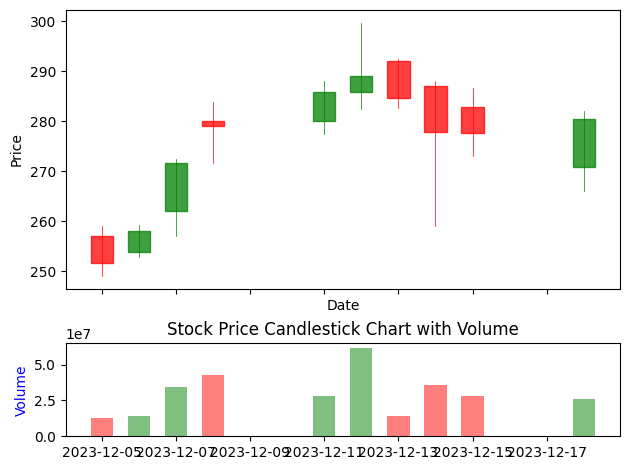

In [74]:
# Convert timestamps to dates
dates = [mdates.epoch2num(timestamp) for timestamp in data['t']]

# Create a list of OHLC (open, high, low, close) tuples
ohlc = list(zip(dates, data['o'], data['h'], data['l'], data['c']))

# Create a figure and axis with two subplots
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot candlestick chart
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r', alpha=0.75)

# Format x-axis as dates
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set axis labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# Plot volume bars
bar_color = ['g' if close_price >= open_price else 'r' for open_price, close_price in zip(data['o'], data['c'])]
ax2.bar(dates, data['v'], color=bar_color, alpha=0.5, width=0.6, align='center')

# Set axis label for volume
ax2.set_ylabel('Volume', color='b')

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.title('Stock Price Candlestick Chart with Volume')
plt.show()

<BarContainer object of 10 artists>

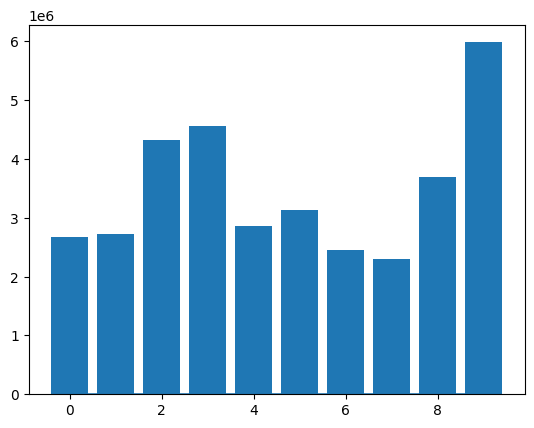

In [45]:
plt.plot(d['c'])
plt.bar(range(10),d['v'])

In [144]:
getStockDetail('IHC')

{'new subsector': 'Hotel, Resort & Restaurants',
 'subsector': 'Hotels',
 'nse id': 'INDHOTEL',
 'full name': 'Indian Hotels Company',
 'main sector': 'Hospitality'}

In [1]:
def get_nse_company_list():
    url = 'https://www.nseindia.com/api/equity-stockIndices'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        companies = data['data']
        return companies
    else:
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        return None

# Get the list of NSE companies
nse_companies = get_nse_company_list()

# Print the list of companies
if nse_companies:
    for company in nse_companies:
        print(f"{company['symbol']} - {company['companyName']}")

NameError: name 'requests' is not defined

In [ ]:
url = 'https://www.nseindia.com/api/equity-stockIndices'
headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
response = requests.get(url, headers=headers)
data = response.json()
